In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('dark')

### Read in data 

In [2]:
X = np.genfromtxt('../data/combined_binned.dat',skip_header=1).T

In [3]:
t,y,s,o=X
ou = np.unique(o)
x_ranges = []
for oo in ou:
    l = o == oo
    x_ranges.append((t[l].min()-0.1,t[l].max()+0.1))
print(x_ranges)
labels = ['XMM1','XMM2','Chandra1','XMM3']

[(476.17578999999995, 476.89547000000005), (499.12255, 500.86769000000004), (528.6104399999999, 529.64377), (634.81236, 636.53899)]


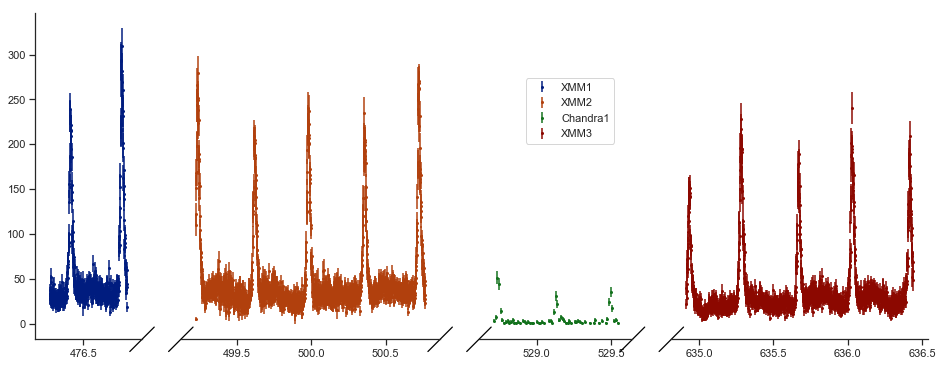

In [4]:
plt.figure(figsize=(16,6))
bax = brokenaxes(xlims=x_ranges)
for i,oo in enumerate(ou):
    l = o == oo
    bax.errorbar(t[l],y[l],yerr=s[l],fmt='.',ms=4,label=labels[i])
bax.legend(loc=(0.55,0.6))

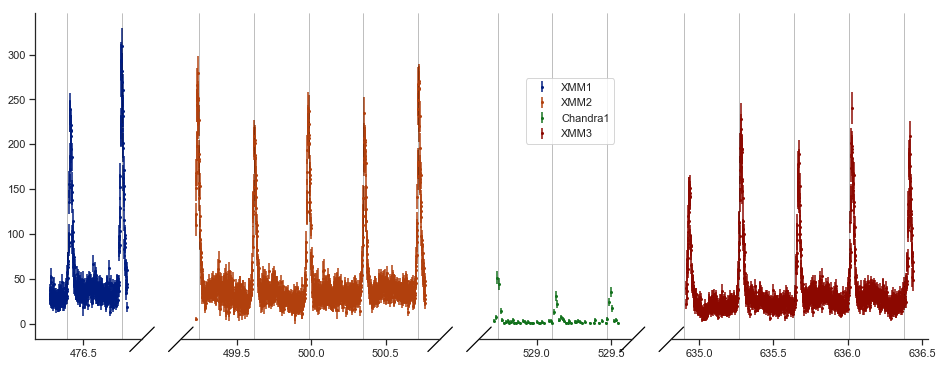

In [5]:
per_init = 0.36863 # from phase-folding
t0_init = t[np.argmax(y)]
while t0_init > t.min():
    t0_init -= per_init
plt.figure(figsize=(16,6))
bax = brokenaxes(xlims=x_ranges)
for i,oo in enumerate(ou):
    l = o == oo
    bax.errorbar(t[l],y[l],yerr=s[l],fmt='.',ms=4,label=labels[i])
t0 = t0_init
while(t0<t.max()):
    t0 += per_init
    bax.axvline(t0,c='k',lw=0.5,alpha=0.5)
bax.legend(loc=(0.55,0.6))

### Functions to fit Gaussian pulses with white noise only

In [6]:
from scipy.optimize import minimize
import emcee, corner

In [7]:
def gauss(p, t):
    amp, mu, sig, dc = p
    return dc + amp * np.exp(-(t-mu)**2/2/sig**2)

def chi2_gauss(p, t, y, e):
    m = gauss(p, t)
    r = y - m
    return ((r/e)**2).sum()

In [8]:
def lnprob_gauss(p, t, y, e):
    return - 0.5 * chi2_gauss(p, t, y, e)

def mcmc_gauss(t, y, e, p_in, nburn = 500, nrun = 500):
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss, args=(t,y,e))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [56]:
def fit_gauss(t, y, e, p_in, axes):
    axes[0].errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first do MLE
    soln = minimize(chi2_gauss,p_in, args = (t,y,e))
    p_mle = soln.x
    treg = np.linspace(min(t), max(t), 200)
    mreg = gauss(p_mle[:4],treg)
    axes[0].plot(treg,mreg,'b-',alpha=0.5)
    # do MCMC
    sampler = mcmc_gauss(t, y, e, p_mle)
    # plot samples
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        mreg = gauss(p,treg)
        axes[0].plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    # MAP parameters & residuals
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    mreg = gauss(p_map,treg)
    axes[0].plot(treg, mreg, "g-",alpha=0.5)
    m = gauss(p_map,t)
    r = y - m
    axes[1].errorbar(t, r, fmt = 'k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # posterior distributions
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r"$A$", r"$\mu$", r"$\sigma$",r"$C$"])
    names = np.array(['amp','loc','half-width','DC'])
    corner_fig = corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up), r, corner_fig

In [123]:
def fit_gauss_all(t, y, e, p_in = per_init, t0_in = t0_init):
    orbit = np.around((t-t0_in)/p_in).astype(int)
    ou = np.unique(orbit)
    orb = []
    par_mle = []
    par_map = []
    par_med = []
    par_err_down = []
    par_err_up = []
    times = []
    fluxes = []
    residuals = []
    errors = []
    no = len(ou)
    nx = 4
    ny = np.ceil(no/nx).astype(int)
    fig1, axes1 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax1 = axes1.flatten()
    fig2, axes2 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax2 = axes2.flatten()
    for io,oo in enumerate(ou):
        print('orbit:', oo)
        l = orbit == oo
        tt = t[l]
        yy = y[l]
        ee = e[l]
        i = np.argmax(yy)
        mu_c = tt[i]
        amp_c = yy[i]
        sig_c = 0.01
        ll = yy > amp_c/2.
        dc_c = np.median(yy[~ll]) 
        par_in = np.array([amp_c, mu_c, sig_c, dc_c])
        print('Initial guess par:', par_in)
        l = abs(tt-mu_c) < (10*sig_c)
        print('no. data points:', l.sum())
        res = fit_gauss(tt[l], yy[l], ee[l], par_in, [ax1[io],ax2[io]])
        names = res[0]
        p_mle, p_map = res[1]
        p_med, p_err_down, p_err_up = res[2]
        resid = res[3]
        par_mle.append(p_mle)
        par_map.append(p_map)
        par_med.append(p_med)
        par_err_down.append(p_err_down)
        par_err_up.append(p_err_up)
        times.append(tt[l])
        fluxes.append(yy[l])
        residuals.append(resid)
        errors.append(ee[l])
        orb.append(oo)
        print('Orbit: {:d}'.format(oo))
        print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
              .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
        for i in range(len(p_mle)):
            print('{:20s} {:15.6f} {:15.6f} {:15.6f} + {:15.6f} - {:15.6f}' \
                  .format(names[i], p_mle[i], p_map[i], p_med[i], p_err_up[i], p_err_down[i]))
        plt.figure(res[-1].number)
        plt.savefig('../plots/gauss_only_corner_orbit_{:03d}.png'.format(oo))
        plt.close(res[-1].number)
        amp_f = p_med[0]
        mu_f = p_med[1]
        sig_f = p_med[2]
        dc_f = p_med[3]
        ax1[io].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
        ax1[io].text(mu_f+5*sig_f,dc_f+0.5*amp_f,'orbit {:d}'.format(oo))
        ax2[io].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
        rmax = resid.max()
        ax2[io].text(mu_f+5*sig_f,rmax,'orbit {:d}'.format(oo))
    plt.figure(fig1.number)
    plt.savefig('../plots/gauss_only_flux.png')
    plt.figure(fig2.number)
    plt.savefig('../plots/gauss_only_residuals.png')
    return orb, par_mle, par_map, par_med, par_err_down, par_err_up, times, fluxes, residuals, errors

orbit: 1
Initial guess par: [2.3966000e+02 4.7641352e+02 1.0000000e-02 3.4260000e+01]
no. data points: 173
Orbit: 1
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       179.677546      179.613149      180.261448 +        4.949901 -        5.051799
loc                       476.415772      476.415797      476.415774 +        0.000246 -        0.000254
half-width                  0.009820        0.009791        0.009817 +        0.000277 -        0.000271
DC                         30.795638       30.892409       30.803577 +        0.629393 -        0.617466
orbit: 2
Initial guess par: [3.0926000e+02 4.7675843e+02 1.0000000e-02 3.5120000e+01]
no. data points: 119
Orbit: 2
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       238.711055      238.835918      238.531316 +        5.192057 -        5.609929
loc                       476.760972      476.760960      476.760974 +        0.000

orbit: 435
Initial guess par: [2.0875000e+02 6.3641584e+02 1.0000000e-02 2.5555000e+01]
no. data points: 107
Orbit: 435
Parameter            ML         MAP        Med        + sig_up     - sig_down  
amp                       146.220350      145.529762      146.004890 +        4.298074 -        4.353832
loc                       636.417281      636.417291      636.417313 +        0.000314 -        0.000330
half-width                  0.011287        0.011310        0.011301 +        0.000343 -        0.000348
DC                         22.493821       22.480289       22.489512 +        0.795533 -        0.758153


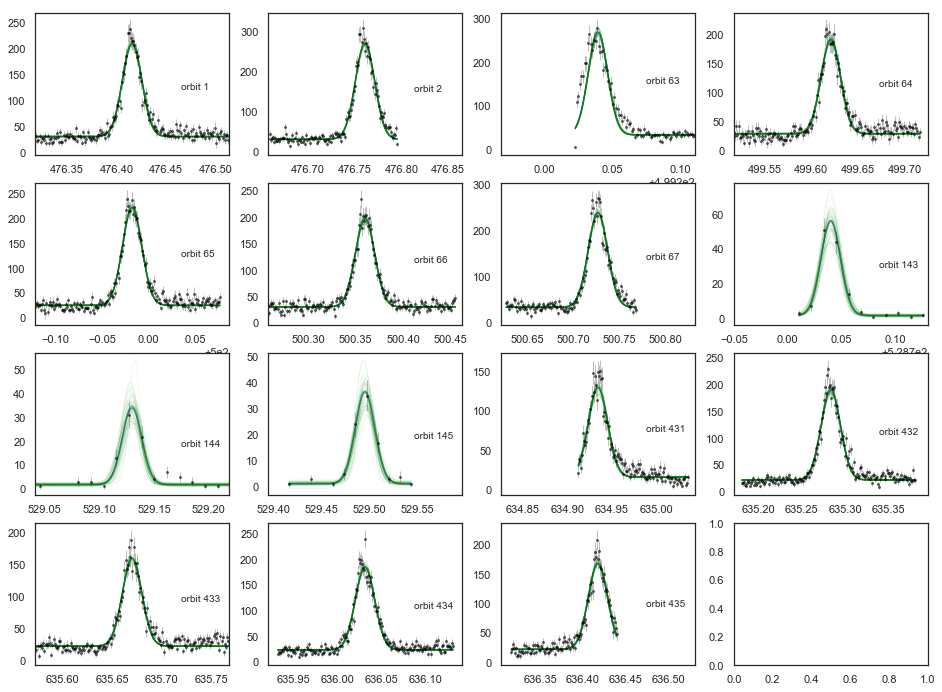

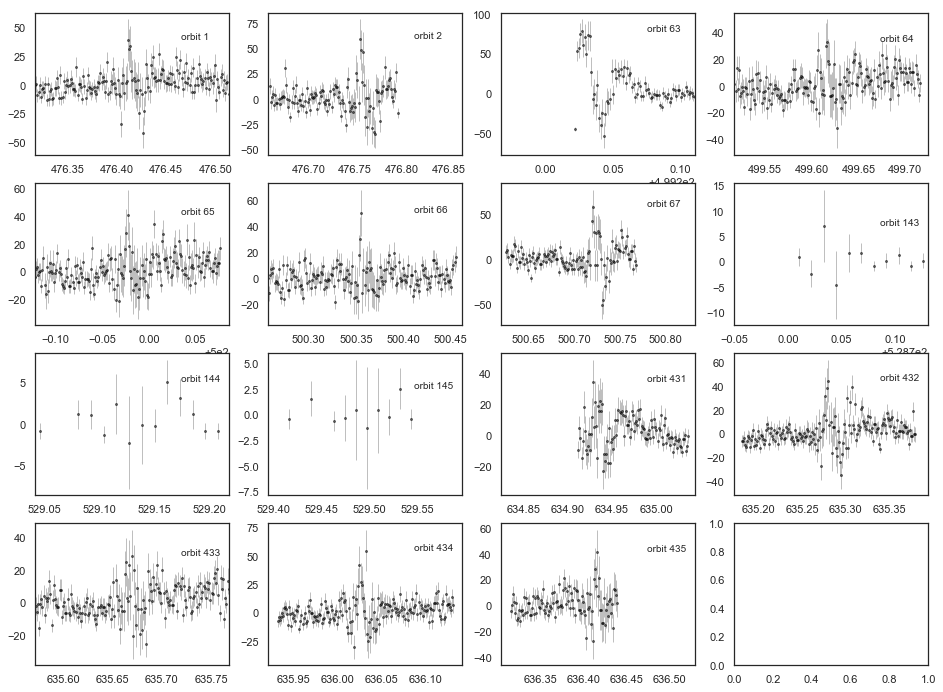

In [124]:
res = fit_gauss_all(t,y,s)

### Now fit residuals with GP

In [125]:
from george import kernels, GP
def nll_gp(p, t, y, e, gp):
    gp.set_parameter_vector(p)
    if abs(p[0]-5)>5:
        return 1e25
    if abs(p[-1]+7)>5:
        return 1e25
    try:
        gp.compute(t, yerr = e)
    except: 
        return 1e25
    return -gp.log_likelihood(y)

In [126]:
def lnprob_gp(p, t, y, e, gp):
    return - nll_gp(p, t, y, e, gp)

def mcmc_gp(t, y, e, gp, nburn = 1000, nrun = 500):
    p_in = gp.get_parameter_vector()
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=(t,y,e,gp))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [127]:
def fit_gp(t, y, e, gp, axes):
    axes[0].errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first to MLE
    p_in = gp.get_parameter_vector()
    soln = minimize(nll_gp,p_in, args = (t,y,e,gp))
    p_mle = soln.x
    gp.set_parameter_vector(p_mle)
    gp.compute(t, yerr=e)
    treg = np.linspace(min(t), max(t), 200)
    mreg = gp.predict(y,treg,return_cov=False,return_var=False)
    axes[0].plot(treg,mreg,'b-',alpha=0.5)
    sampler = mcmc_gp(t, y, e, gp)
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        gp.set_parameter_vector(p)
        gp.compute(t, yerr=e)
        mreg = gp.sample_conditional(y,treg).flatten()        
        axes[0].plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    gp.set_parameter_vector(p_map)
    gp.compute(t, yerr=e)
    mreg, sreg = gp.predict(y,treg,return_cov=False,return_var=True)
    sreg = np.sqrt(sreg)
    axes[0].plot(treg, mreg, "r-", alpha = 0.5)
    axes[0].fill_between(treg, mreg+sreg,mreg-sreg, color="r", alpha=0.2,lw = 0.0)
    m = gp.predict(y,t,return_cov=False,return_var=False)
    r = y - m
    axes[1].errorbar(t, r, fmt = 'k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r'$\log(V)$',r'$\log(m)$'])
    names = np.array(['log_var','log_metric'])
    corner_fig = corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up), corner_fig

In [128]:
def fit_gp_all(t, y, e):
    n = len(t)
    HPs = np.zeros((n,2))
    nx = 4
    ny = np.ceil(n/nx).astype(int)
    fig1, axes1 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax1 = axes1.flatten()
    fig2, axes2 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax2 = axes2.flatten()
    for i in range(n):
        v = np.var(y[i])
        m = np.exp(-7)
        k = v * kernels.ExpSquaredKernel(m)
        gp = GP(k,mean = 0.0, fit_mean=False)
        res = fit_gp(t[i], y[i], e[i], gp, [ax1[i], ax2[i]])
        names = res[0]
        p_mle, p_map = res[1]
        p_med, p_err_down, p_err_up = res[2]
        print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
                .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
        for j in range(len(p_mle)):
            print('{:20s} {:10.1f} {:10.1f} {:10.1f} + {:10.1f} - {:10.1f}' \
                  .format(names[j], p_mle[j], p_map[j], p_med[j], p_err_up[j], p_err_down[j]))
        HPs[i,:] = p_map
        plt.figure(res[-1].number)
        plt.savefig('../plots/gp_only_corner_block_{:03d}.png'.format(i+1))
#        rmax = y[i].max()
#        
#        ax1[io].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
#        ax1[io].text(mu_f+5*sig_f,dc_f+0.5*amp_f,'orbit {:d}'.format(oo))
#        ax2[io].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
#        ax2[io].text(mu_f+5*sig_f,rmax,'orbit {:d}'.format(oo))
    plt.figure(fig1.number)
    plt.savefig('../plots/gp_only_flux.png')
    plt.figure(fig2.number)
    plt.savefig('../plots/gp_only_residuals.png')
    return HPs

Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     3.0        3.0        3.2 +        1.3 -        0.9
log_metric                 -5.8       -5.8       -5.7 +        1.1 -        1.2
Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     0.1        3.8        3.8 +        0.5 -        0.5
log_metric                 -7.3      -12.0      -11.6 +        0.5 -        0.3
Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                    10.0       10.0        8.5 +        1.1 -        1.6
log_metric                 -9.0       -9.0       -9.6 +        0.5 -        1.2
Parameter            ML         MAP        Med        + sig_up     - sig_down  
log_var                     3.1        3.2        3.1 +        0.8 -        0.6
log_metric                 -5.6       -9.6       -7.8 +        2.6 -        1.9
Parameter            ML         MAP     

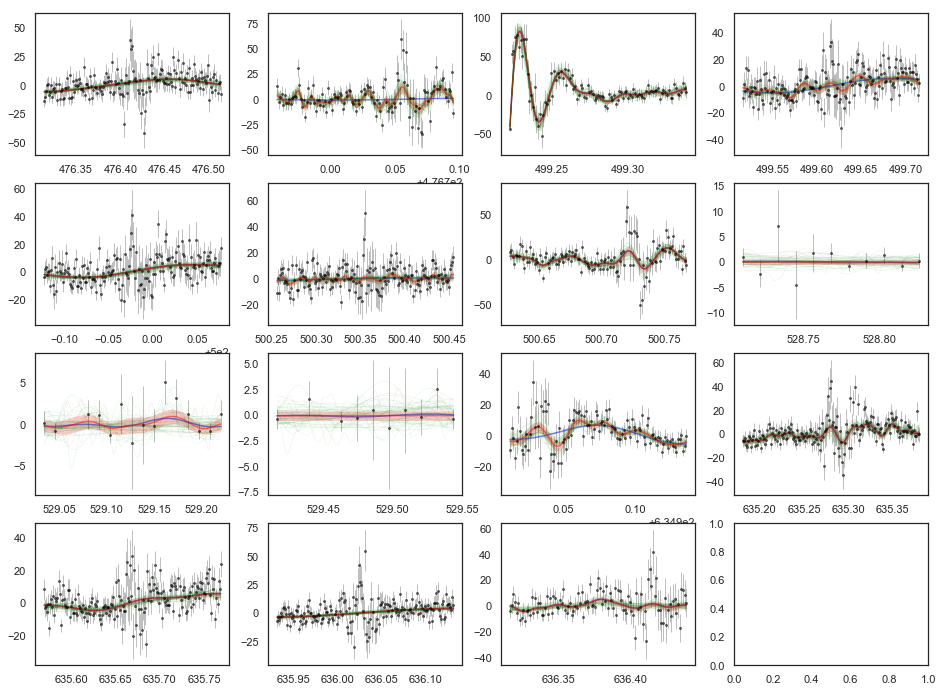

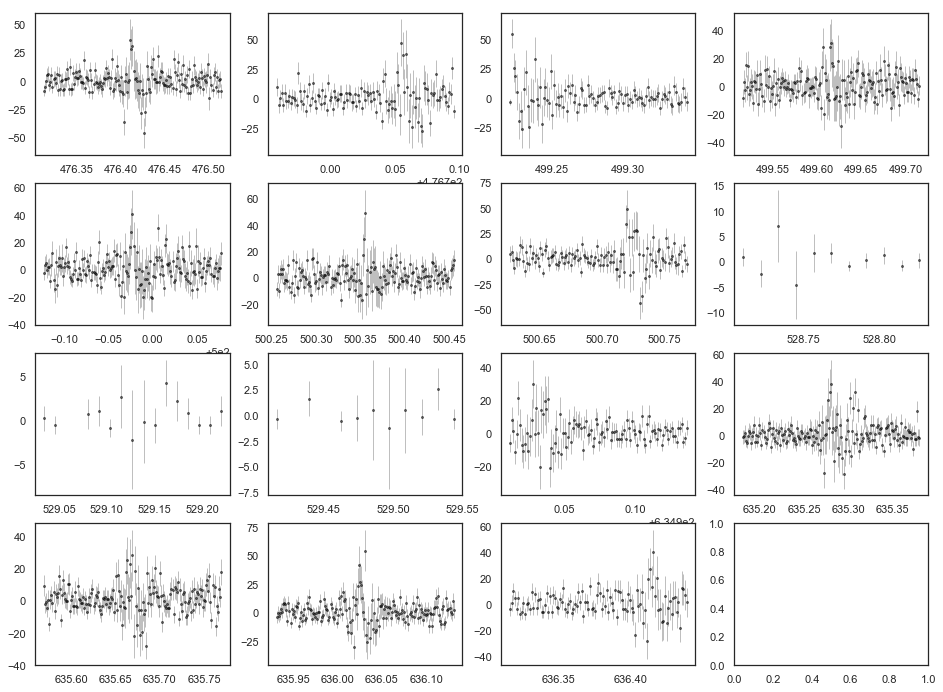

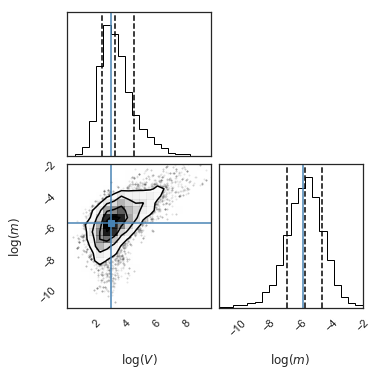

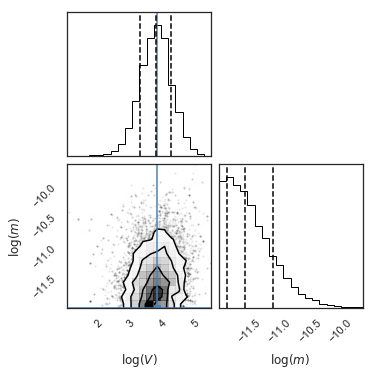

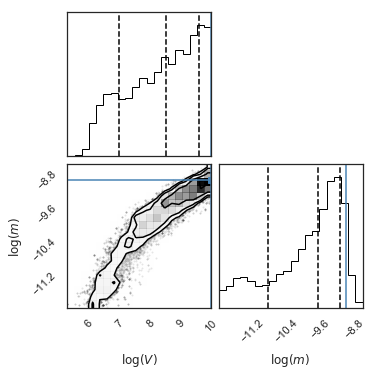

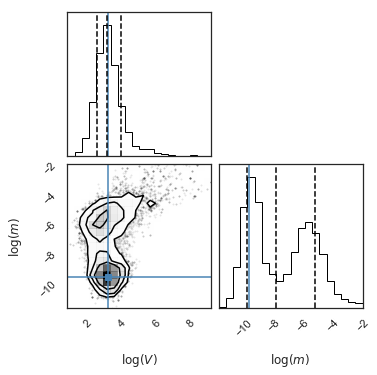

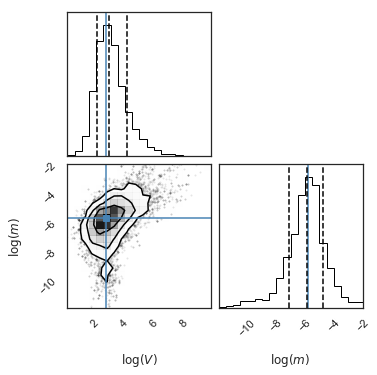

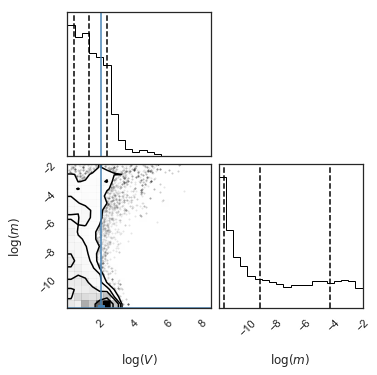

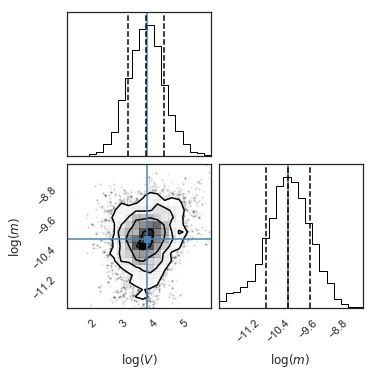

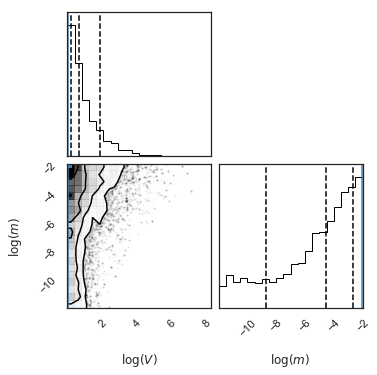

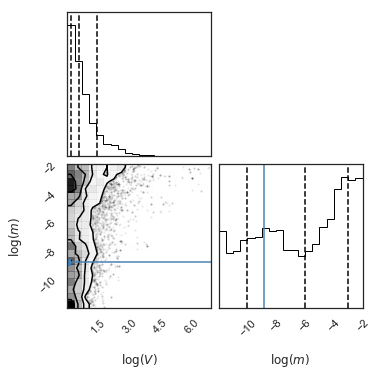

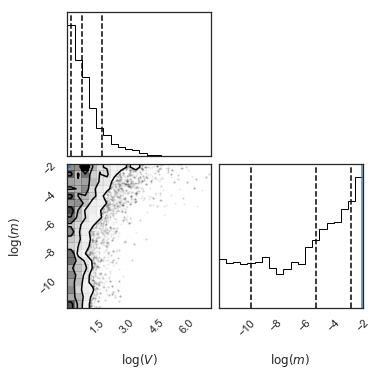

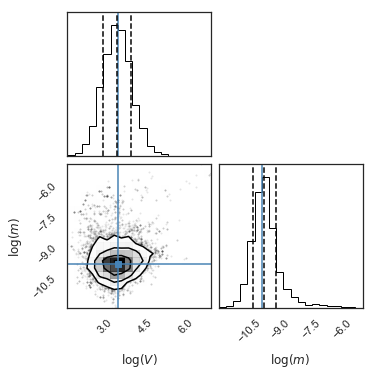

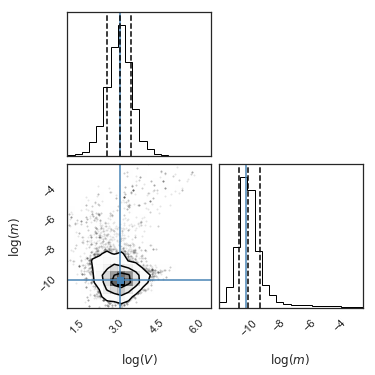

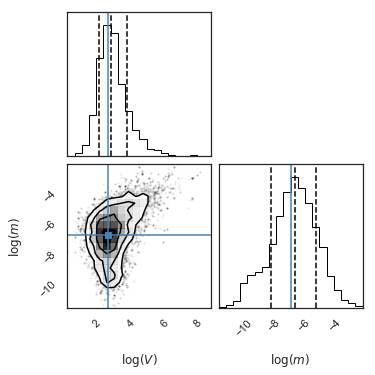

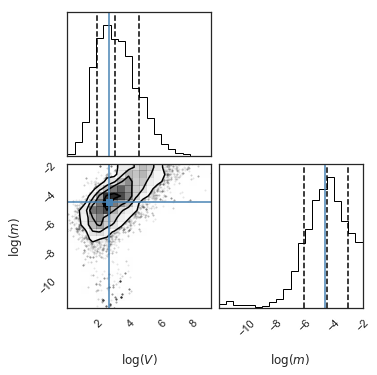

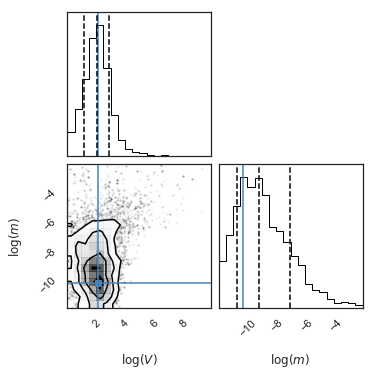

In [130]:
times, fluxes, residuals, errors = res[-4:]
HPs = fit_gp_all(times, residuals, errors)

### Now fit Gaussian + GP, using previous exercise to set the initial values

In [197]:
def nll_gauss_gp(p, t, y, e, gp):
    if abs(p[-2]-5)>5:
        return 1e25
    if abs(p[-1]+7)>5:
        return 1e25
    if abs(p[2]-0.01)>0.01:
        return 1e25
    gp.set_parameter_vector(p[4:])
    try:
        gp.compute(t, yerr = e)
    except: 
        return 1e25
    m = gauss(p[:4], t)
    r = y - m
    return -gp.log_likelihood(r)

In [198]:
def lnprob_gauss_gp(p, t, y, e, gp):
    return - nll_gauss_gp(p, t, y, e, gp)

def mcmc_gauss_gp(t, y, e, p_gauss_in, gp, nburn = 1000, nrun = 500):
    p_in = np.concatenate([p_gauss_in, gp.get_parameter_vector()])
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss_gp, args=(t,y,e,gp))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, nburn)
    sampler.reset()
    sampler.run_mcmc(p0, nrun)
    return sampler

In [208]:
def fit_gauss_gp(t, y, e, gp, p_in, axes):
    # first do MLE
    soln = minimize(nll_gauss_gp,p_in, args = (t,y,e,gp))
    p_mle = soln.x
    # do MCMC
    sampler = mcmc_gauss_gp(t, y, e, p_mle[:4], gp)
    # extract MAP parameters
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    # compute MAP model and residuals
    g = gauss(p_map[:4],t)
    r1 = y - g
    gp.set_parameter_vector(p_map[-2:])
    gp.compute(t, yerr=e)
    mu = gp.predict(r1, t, return_cov = False, return_var = False)
    r2 = y - mu
    r = y - g - mu 
    # plot data
    axes[0].errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5) # input
    axes[1].errorbar(t,r2,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5) # minus GP
    axes[2].errorbar(t,r1,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5) # minus Gaussian
    axes[3].errorbar(t,r,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5) # overall residuals
    # plot best-fit model evaluated on a regular grid
    treg = np.linspace(min(t), max(t), 200)
    gauss_reg = gauss(p_map[:4],treg)
    gp_reg = gp.predict(r1, treg, return_cov=False, return_var=False)
    axes[0].plot(treg, gauss_reg + gp_reg, 'g-', alpha = 0.5)
    axes[1].plot(treg, gauss_reg, 'g-', alpha = 0.5)
    axes[2].plot(treg, gp_reg, 'g-', alpha = 0.5)
    # plot samples from MCMC
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        gauss_reg = gauss(p[:4],treg)
        g = gauss(p[:4],t)
        r1 = y - g
        gp.set_parameter_vector(p[-2:])
        try:
            gp.compute(t, yerr=e)
        except: 
            continue
    # posterior distributions
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r"$A$", r"$\mu$", r"$\sigma$",r"$C$",r'$\log(V)$',r'$\log(m)$'])
    names = np.array(['amp','loc','half-width','DC','log_var','log_metric'])
#    corner_fig = corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    corner_fig = plt.figure()
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up), r, corner_fig

In [211]:
def fit_gauss_gp_all(t, y, e, p_gauss_in, p_gp_in, orbits):
    par_mle = []
    par_map = []
    par_med = []
    par_err_down = []
    par_err_up = []
    residuals = []
    n = len(t)
    nx = 4
    ny = np.ceil(n/nx).astype(int)
    fig1, axes1 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax1 = axes1.flatten()
    fig2, axes2 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax2 = axes2.flatten()
    fig3, axes3 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax3 = axes3.flatten()
    fig4, axes4 = plt.subplots(ny,nx,figsize=(nx*4,ny*3))
    ax4 = axes4.flatten()
    for i in range(n):
        p_in = np.concatenate([p_gauss_in[i],p_gp_in[i]])
        k = 1.0 * kernels.ExpSquaredKernel(1.0)
        gp = GP(k,mean = 0.0, fit_mean=False)
        oo = orbits[i]
        if oo==63:
            tt = t[i]
            yy = y[i]
            ee = e[i]
            l = yy > 10
            t[i] = tt[l]
            y[i] = yy[l]
            e[i] = ee[l]
        res = fit_gauss_gp(t[i], y[i], e[i], gp, p_in, [ax1[i], ax2[i], ax3[i], ax4[i]])
        names = res[0]
        p_mle, p_map = res[1]
        p_med, p_err_down, p_err_up = res[2]
        resid = res[3]
        par_mle.append(p_mle)
        par_map.append(p_map)
        par_med.append(p_med)
        par_err_down.append(p_err_down)
        par_err_up.append(p_err_up)
        residuals.append(resid)        
        print('{:20s} {:15s} {:15s} {:15s} + {:15s} - {:15s}' \
                .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
        for j in range(len(p_mle)):
            print('{:20s} {:15.5f} {:15.5f} {:15.5f} + {:15.5f} - {:15.5f}' \
                  .format(names[j], p_mle[j], p_map[j], p_med[j], p_err_up[j], p_err_down[j]))
        plt.figure(res[-1].number)
        plt.savefig('../plots/gauss_gp_corner_block_{:03d}.png'.format(i+1))
        plt.close(res[-1].number)
        amp_f = p_med[0]
        mu_f = p_med[1]
        sig_f = p_med[2]
        dc_f = p_med[3]
        ax1[i].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
        ax1[i].text(mu_f+5*sig_f,dc_f+0.5*amp_f,'orbit {:d}'.format(oo))
        ax2[i].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
        ax2[i].text(mu_f+5*sig_f,dc_f+0.5*amp_f,'orbit {:d}'.format(oo))
        ax3[i].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
        rmax = resid.max()
        ax3[i].text(mu_f+5*sig_f,rmax,'orbit {:d}'.format(oo))
        ax4[i].set_xlim(mu_f-10*sig_f,mu_f+10*sig_f)
        ax4[i].text(mu_f+5*sig_f,rmax,'orbit {:d}'.format(oo))
    plt.figure(fig1.number)
    plt.savefig('../plots/gauss_gp_flux.png')
    plt.figure(fig2.number)
    plt.savefig('../plots/gauss_gp_flux_corrected.png')
    plt.figure(fig3.number)
    plt.savefig('../plots/gauss_gp_residuals.png')
    return par_mle, par_map, par_med, par_err_down, par_err_up, residuals

Parameter            ML              MAP             Med             + sig_up          - sig_down       
amp                        178.35946       178.98089       177.88509 +         5.41713 -         6.19488
loc                        476.41549       476.41552       476.41551 +         0.00024 -         0.00024
half-width                   0.00917         0.00926         0.00922 +         0.00032 -         0.00036
DC                          30.05905        29.19768        29.05029 +         6.76076 -        12.04505
log_var                      3.48370         3.43478         4.57309 +         2.07709 -         1.28818
log_metric                  -5.65311        -5.71131        -5.30105 +         1.37581 -         1.00855
Parameter            ML              MAP             Med             + sig_up          - sig_down       
amp                        239.22585       240.68671       242.88705 +        10.51182 -         8.21618
loc                        476.76061       476.76054   

Parameter            ML              MAP             Med             + sig_up          - sig_down       
amp                        135.26584       135.77605       135.49110 +         6.38354 -         6.75473
loc                        635.66940       635.66940       635.66950 +         0.00038 -         0.00046
half-width                   0.00957         0.00954         0.00956 +         0.00055 -         0.00061
DC                          24.24572        24.33198        24.33267 +         3.78340 -         2.89251
log_var                      2.89866         3.09352         3.52009 +         1.19647 -         0.76086
log_metric                  -7.44836        -7.57870        -7.23221 +         1.40194 -         1.12993
Parameter            ML              MAP             Med             + sig_up          - sig_down       
amp                        162.20034       162.48759       162.26600 +         4.29457 -         4.46141
loc                        636.03102       636.03101   

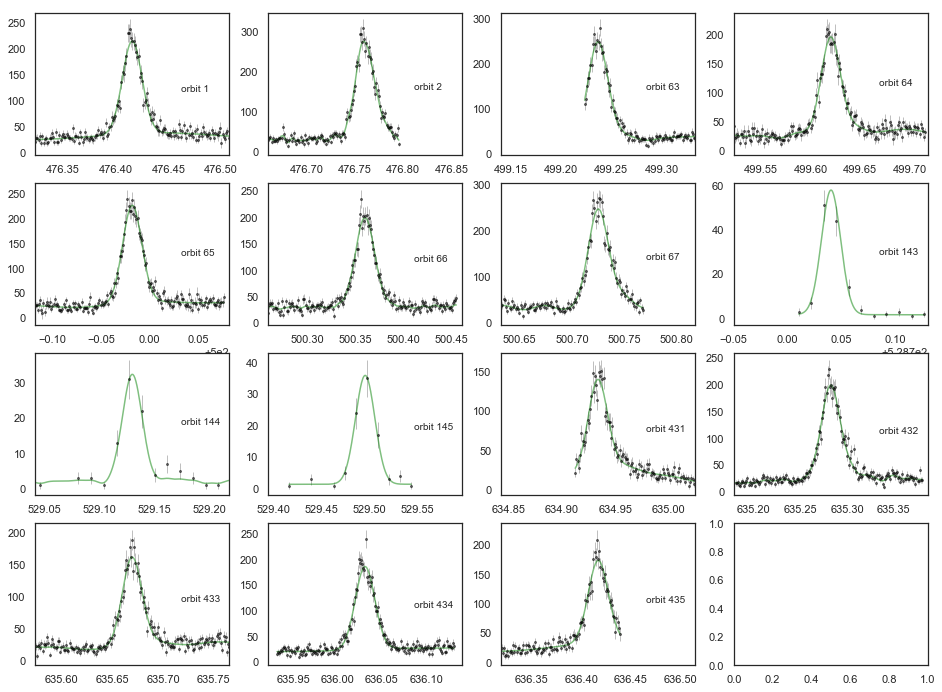

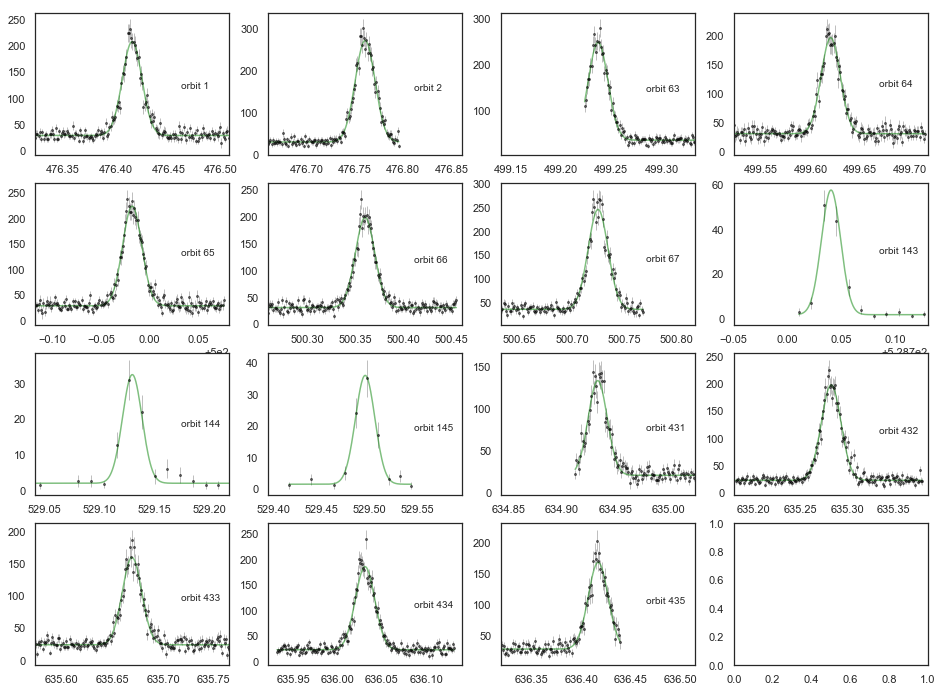

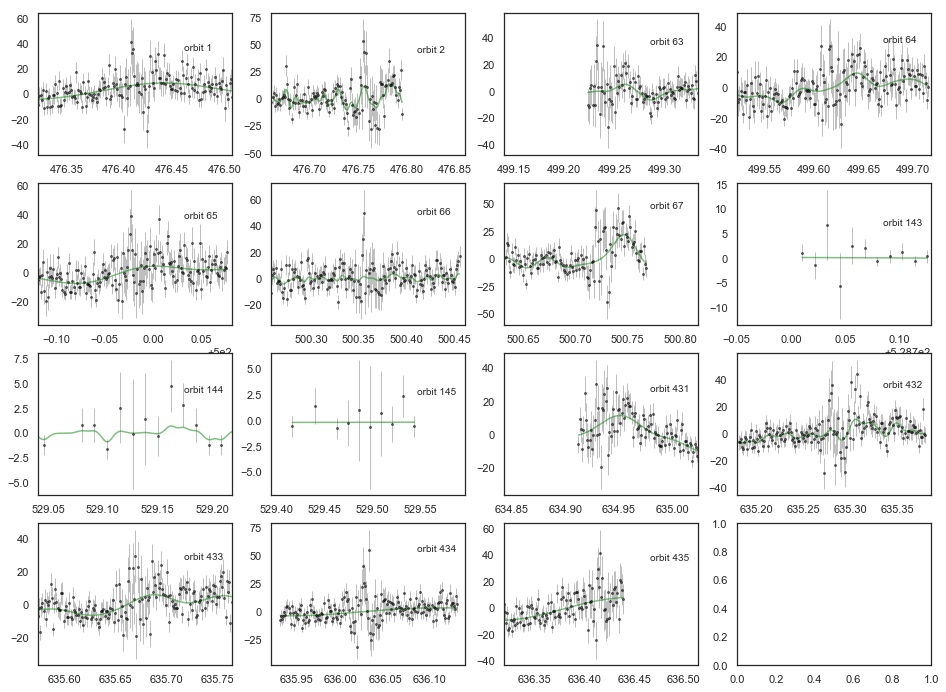

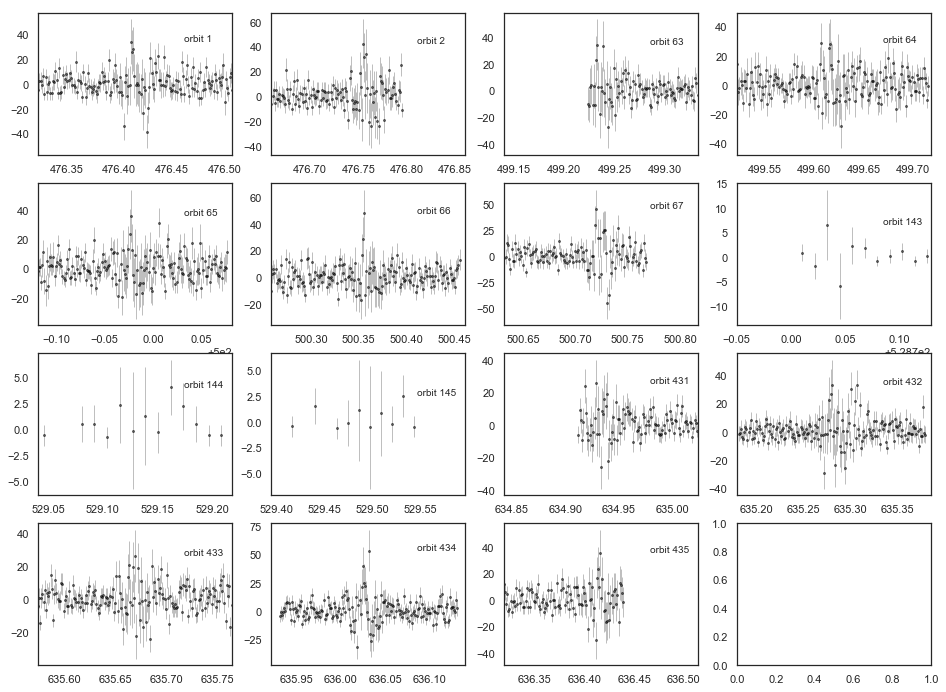

In [212]:
res2 = fit_gauss_gp_all(times, fluxes, errors, res[2], HPs, res[0])

### Any evidence of period drift so far?

In [213]:
orb = res[0]
par_med, par_err_up, par_err_down = res2[2], res2[3], res2[4]
orbit_no = np.array(orb)/2.
pulse_time = np.zeros_like(orbit_no,float)
pulse_time_err = np.zeros_like(pulse_time)
pulse_width = np.zeros_like(orbit_no,float)
pulse_width_err = np.zeros_like(pulse_time)
pulse_amp = np.zeros_like(orbit_no,float)
pulse_amp_err = np.zeros_like(pulse_time)
pulse_dt = []
pulse_dt_err = []
print('')
for i in range(len(orbit_no)):
    pulse_amp[i] = par_med[i][0]
    pulse_amp_err[i] = 0.5 * (par_err_up[i][0] + par_err_down[i][0])
    pulse_time[i] = par_med[i][1]
    pulse_time_err[i] = 0.5 * (par_err_up[i][1] + par_err_down[i][1])
    pulse_width[i] = abs(par_med[i][2])
    pulse_width_err[i] = 0.5 * (par_err_up[i][2] + par_err_down[i][2])
    l = orbit_no == orbit_no[i]-1
    if l.any():
        lst, lste = pulse_time[l], pulse_time_err[l]
        pulse_dt.append(pulse_time[i] - lst)
        pulse_dt_err.append(np.sqrt(pulse_time_err[i]**2 + pulse_time_err[l]**2))
        print(orbit_no[i],pulse_dt[-1]*24,pulse_dt_err[-1]*24)


32.5 [17.88338924] [0.01332799]
33.0 [17.75048441] [0.01351132]
33.5 [17.82507325] [0.01755524]
72.5 [18.13488337] [0.04322834]
216.5 [17.66068378] [0.01591352]
217.0 [17.96036301] [0.01347193]
217.5 [17.93675408] [0.01445584]


In [214]:
pulse_dt = np.array(pulse_dt)
pulse_dt_err = np.array(pulse_dt_err)
dt_start = (pulse_dt[:3]/pulse_dt_err[:3]**2).sum() / (1./pulse_dt_err[:3]**2).sum()
dt_end = (pulse_dt[-3:]/pulse_dt_err[-3:]**2).sum() / (1./pulse_dt_err[-3:]**2).sum()
dt_start_err1 = np.mean(pulse_dt_err[:3])/np.sqrt(3)
dt_end_err1 = np.mean(pulse_dt_err[-3:])/np.sqrt(3)
dt_start_err2 = np.std(pulse_dt[:3])/np.sqrt(3)
dt_end_err2 = np.std(pulse_dt[-3:])/np.sqrt(3)
print(dt_start*24,dt_start_err1*24,dt_start_err2*24)
print(dt_end*24,dt_end_err1*24,dt_end_err2*24)

17.81947890581051 0.008543735194877881 0.031404142964642986
17.86935244343104 0.008437260312610613 0.07854695180789804


Text(0.5, 0, 'orbit number')

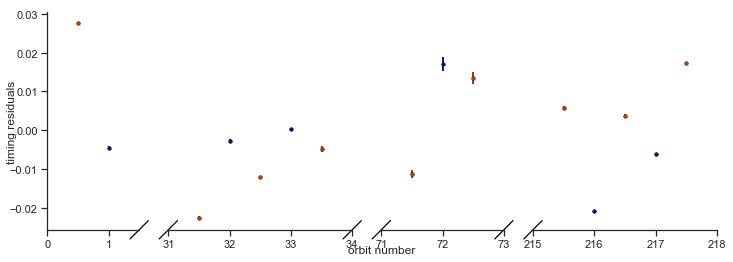

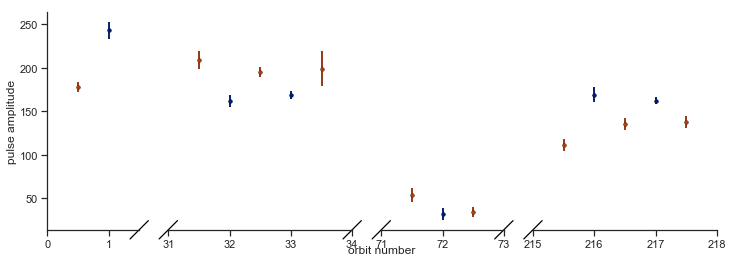

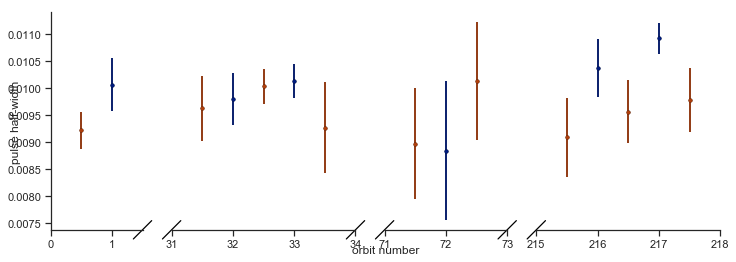

In [217]:
l1 = (orbit_no%1)==0
l2 = (orbit_no%1)==0.5

p = np.polyfit(orbit_no,pulse_time,1)
v = np.polyval(p,orbit_no)
time_res = (pulse_time - v) / p[-2]
x_ranges_2 = ((0,1.5),(31,34),(71,73),(215,218))
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges_2)
bax.errorbar(orbit_no,time_res,yerr=pulse_time_err,fmt='k.')
bax.errorbar(orbit_no[l1],time_res[l1],yerr=pulse_time_err[l1],fmt='.')
bax.errorbar(orbit_no[l2],time_res[l2],yerr=pulse_time_err[l2],fmt='.')
bax.set_ylabel('timing residuals')
bax.set_xlabel('orbit number')
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges_2)
bax.errorbar(orbit_no,pulse_amp,yerr=pulse_amp_err,fmt='k.')
bax.errorbar(orbit_no[l1],pulse_amp[l1],yerr=pulse_amp_err[l1],fmt='.')
bax.errorbar(orbit_no[l2],pulse_amp[l2],yerr=pulse_amp_err[l2],fmt='.')
bax.set_ylabel('pulse amplitude')
bax.set_xlabel('orbit number')
plt.figure(figsize=(12,4))
bax = brokenaxes(xlims=x_ranges_2)
bax.errorbar(orbit_no,pulse_width,yerr=pulse_width_err,fmt='k.')
bax.errorbar(orbit_no[l1],pulse_width[l1],yerr=pulse_width_err[l1],fmt='.')
bax.errorbar(orbit_no[l2],pulse_width[l2],yerr=pulse_width_err[l2],fmt='.')
bax.set_ylabel('pulse half-width')
bax.set_xlabel('orbit number')

In [ ]:
tsel, rsel, esel = res[-3:]
HPs = fit_gp_all(tsel, rsel, esel)

In [ ]:
def fit_gauss_gp(t, y, e, p_gauss_in, gp):
    plt.figure()
    plt.errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first to MLE
    p_gp_in = gp.get_parameter_vector()
    p_in = np.concatenate([p_gauss_in,p_gp_in])
    soln = minimize(nll_gauss_gp,p_in, args = (t,y,e,gp))
    p_mle = soln.x
    gp.set_parameter_vector(p_mle[-2:])
    gp.compute(t, yerr=e)
    m_mle = gauss(p_mle[:4], t)
    r_mle = y - m_mle
    treg = np.linspace(min(t), max(t), 200)
    mreg = gauss(p_mle[:4], treg) + gp.predict(r_mle,treg,return_cov=False,return_var=False)
    plt.plot(treg,mreg,'b-')
    sampler = mcmc_gauss_gp(t, y, e, p_mle[:4], gp)
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        gp.set_parameter_vector(p[-2:])
        gp.compute(t, yerr=e)
        m = gauss(p[:4],t)
        r = y - m
        mreg = gauss(p[:4],treg) + gp.sample_conditional(r,treg).flatten()        
        plt.plot(treg, mreg, "g-", alpha=0.1,lw = 0.5)
    samples = sampler.flatchain
    logL = sampler.flatlnprobability
    p_map = samples[np.argmax(logL),:].flatten()
    gp.set_parameter_vector(p_map[-2:])
    gp.compute(t, yerr=e)
    m_map = gauss(p_map[:4], t)
    r_map = y - m_map
    mreg = gauss(p_map[:4], treg)
    mreg_gp, vreg_gp = gp.predict(r_map,treg,return_cov=False,return_var=True)
    sreg_gp = np.sqrt(vreg_gp)
    mreg_gp += mreg
    plt.plot(treg, mreg, ls="-",color='orange')
    plt.plot(treg, mreg_gp, "r-",lw = 0.5)
    plt.fill_between(treg, mreg_gp+sreg_gp,mreg_gp-sreg_gp, color="r", alpha=0.1,lw = 0.0)
    ndim = len(p_map)
    p_med = np.zeros(ndim)
    p_err_down = np.zeros(ndim)
    p_err_up = np.zeros(ndim)
    for i in range(ndim):
        p = samples[:,i].flatten()
        l,m,u = np.percentile(p, [16, 50, 84])
        p_med[i] = m
        p_err_down[i] = m-l
        p_err_up[i] = u-m
    labels = np.array([r"$A$", r"$\mu$", r"$\sigma$",r"$C$",r'$\log(V)$',r'$\log(m)$'])
    names = np.array(['amp','loc','half-width','DC','log_var','log_metric'])
    corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],truths=p_map,labels=labels)
    return names, (p_mle, p_map),(p_med,p_err_down,p_err_up)

In [ ]:
def fit_gauss_gp_all(t, y, e, p_gauss_in, gp_HPs_in):
    n_orbit = len(p_gauss_in)
    orbit = []
    par_mle = []
    par_map = []
    par_med = []
    par_err_down = []
    par_err_up = []
    for io in range(n_orbit):
    
    k = gp_var * kernels.ExpSquaredKernel(gp_metric)
        gp = GP(k,mean = 0, fit_mean=False)
        p_in = np.concatenate([p_in, gp.get_parameter_vector()])
    
    w = 14 * sig_in
    t0 = t0_in
    p_in = np.array([amp_in,t0,sig_in,np.median(y)])
    if use_gp:
    while (t0 - w/2.) < t.max():
        l = abs(t-t0) <= (w/2.)
        if l.sum() > 0:
            p_in[1] = t0
            print(p_in)
            if use_gp:
                p_mle, p_map, p_med, p_err_down, p_err_up, names = fit_gauss(t[l], y[l], e[l], p_in, gp)
            else:
                p_mle, p_map, p_med, p_err_down, p_err_up, names = fit_gauss(t[l], y[l], e[l], p_in)
            p_in = p_map
            par_mle.append(p_mle)
            par_map.append(p_map)
            par_med.append(p_med)
            par_err_down.append(p_err_down)
            par_err_up.append(p_err_up)
            orbit.append(o)
            print('Orbit: {:d}'.format(o))
            print('{:20s} {:10s} {:10s} {:10s} + {:10s} - {:10s}' \
                  .format('Parameter','ML', 'MAP', 'Med', 'sig_up', 'sig_down'))
            for i in range(len(p_mle)):
                print('{:20s} {:10.1f} {:10.1f} {:10.1f} + {:10.1f} - {:10.1f}' \
                      .format(names[i], p_mle[i], p_map[i], p_med[i], p_err_up[i], p_err_down[i]))
        t0 += per_in
        o += 1
    return orbit, par_mle, par_map, par_med, par_err_down, par_err_up

### Now do it with GP

<font color=red>To use GP need to first fit without GP, model residuals with GP to initialise HPs, then do joint fit.</font>

In [ ]:
res = fit_gauss_all(tbin,ybin,sbin,use_gp=True)

### So which parameters vary from pulse to pulse and how much?

#### <font color=red>TBD: fit ephemeris properly:</font>
- <font color=red>accounting for individual uncertainties on individual times</font>
- <font color=red>using one period for all pulses but different offsets for odd and even</font>
- <font color=red>computing uncertainties on ephemeris parameters</font>

In [ ]:
orbit, amp_fit, mu_fit, sig_fit, dc_fit, amp_err, mu_err, sig_err, dc_err = res
fig,axes = plt.subplots(5,1,figsize=(10,10),sharex =True)
axes[0].errorbar(orbit,amp_fit,yerr=amp_err,fmt='.')
axes[1].errorbar(orbit,mu_fit,yerr=mu_err,fmt='.')
orb = np.array(orbit)
mus = np.array(mu_fit)
mue = np.array(mu_err)
l_odd = (orb%2)==1
print(l_odd)
l_even = ~l_odd
print(l_even)
p_odd = np.polyfit(orb[l_odd],mus[l_odd],1)
v_odd = np.polyval(p_odd,orb[l_odd])
print(p_odd)
p_even = np.polyfit(orb[l_even],mus[l_even],1)
print(p_even)
v_even = np.polyval(p_even,orb[l_even])
p_even = np.polyfit(np.array(orbit)[1::2],np.array(mu_fit)[1::2],1)
axes[2].errorbar(orb[l_odd],mus[l_odd]-v_odd,yerr=mue[l_odd],fmt='.',color='r')
axes[2].errorbar(orb[l_even],mus[l_even]-v_even,yerr=mue[l_even],fmt='.',color='b')
axes[3].errorbar(orbit,sig_fit,yerr=sig_err,fmt='.')
axes[4].errorbar(orbit,dc_fit,yerr=dc_err,fmt='.')
axes[0].set_ylabel('amplitude')
axes[1].set_ylabel('position')
axes[2].set_ylabel('O-C')
axes[3].set_ylabel('half-width')
axes[4].set_ylabel('dc level')
axes[4].set_xlabel('orbit number')


### In case I accidentally delete cells containing important functions again...

In [ ]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))